In [22]:
import re
import nltk
import pandas as pd
nltk.download('punkt')

import emoji
import numpy as np
from nltk.tokenize import word_tokenize
from tqdm import tqdm
tqdm.pandas()
from tqdm import trange
#from utils2 import get_dict

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kemalcankara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
# Define the 'tokenize' function that will include the steps previously seen
def tokenize(corpus):
    data = re.sub(r'[,!?;-]+', '.', corpus)
    data = nltk.word_tokenize(data)  # tokenize string to words
    data = [ ch.lower() for ch in data
             if ch.isalpha()
             or ch == '.'
             or emoji.get_emoji_regexp().search(ch)
           ]
    return data

In [3]:
# Define new corpus
corpus = 'It is wednesday and it is raining'

# Print new corpus
print(f'Corpus:  {corpus}')

# Save tokenized version of corpus into 'words' variable
words = tokenize(corpus)

# Print the tokenized version of the corpus
print(f'Words (tokens):  {words}')

Corpus:  It is wednesday and it is raining
Words (tokens):  ['it', 'is', 'wednesday', 'and', 'it', 'is', 'raining']


In [4]:
# Define the 'get_windows' function
def get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1

In [5]:
for x, y in get_windows(['It','is','wednesday','and','it','is','raining'], 2):
    print(f'{x}\t{y}')

['It', 'is', 'and', 'it']	wednesday
['is', 'wednesday', 'it', 'is']	and
['wednesday', 'and', 'is', 'raining']	it


In [24]:
#define get_dict() function
def get_dict(words):
    # This function returns:
    # - word2Ind: dictionary mapping each unique word to a unique index
    # - Ind2word: dictionary mapping each unique index to a unique word

    # Get unique words using set()
    vocab = set(words)

    # Dictionaries to return
    word2Ind = {}
    Ind2word = {}

    # Loop through 'vocab' and create the dictionaries
    for i, word in enumerate(vocab):
        word2Ind[word] = i
        Ind2word[i] = word

    return word2Ind, Ind2word

# Get 'word2Ind' and 'Ind2word' dictionaries for the tokenized corpus
word2Ind, Ind2word = get_dict(words)

In [25]:
Ind2word

{0: 'raining', 1: 'it', 2: 'wednesday', 3: 'is', 4: 'and'}

In [26]:
# Print value for the key '2' within Ind2word dictionary
print("Word which has index 2:  ",Ind2word[2] )

Word which has index 2:   wednesday


In [9]:
# Save length of word2Ind dictionary into the 'V' variable
V = len(word2Ind)

# Print length of word2Ind dictionary
print("Size of vocabulary: ", V)

Size of vocabulary:  5


In [10]:
# Create vector with the same length as the vocabulary, filled with zeros
center_word_vector = np.zeros(V)

# Print vector
center_word_vector

array([0., 0., 0., 0., 0.])

In [11]:
# Replace element number 'n' with a 1
center_word_vector[2] = 1
center_word_vector

array([0., 0., 1., 0., 0.])

In [29]:
# Define the 'word_to_one_hot_vector' function that will include the steps previously seen
def word_to_one_hot_vector(word, word2Ind, V):
    one_hot_vector = np.zeros(V)
    one_hot_vector[word2Ind[word]] = 1
    return one_hot_vector

In [33]:
V=5

In [34]:
word_to_one_hot_vector('wednesday', word2Ind, 5)

array([0., 0., 1., 0., 0.])

In [35]:
context_words = ['it', 'is', 'and', 'it']
# Create one-hot vectors for each context word using list comprehension
context_words_vectors = [word_to_one_hot_vector(w, word2Ind, V) for w in context_words]

context_words_vectors

[array([0., 1., 0., 0., 0.]),
 array([0., 0., 0., 1., 0.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 1., 0., 0., 0.])]

In [15]:
# Compute mean of the vectors using numpy
np.mean(context_words_vectors, axis=0)

array([0.  , 0.5 , 0.  , 0.25, 0.25])

In [36]:
# Define the 'context_words_to_vector' function that will include the steps previously seen
def context_words_to_vector(context_words, word2Ind, V):
    context_words_vectors = [word_to_one_hot_vector(w, word2Ind, V) for w in context_words]
    context_words_vectors = np.mean(context_words_vectors, axis=0)
    return context_words_vectors

In [37]:
words

['it', 'is', 'wednesday', 'and', 'it', 'is', 'raining']

In [38]:
# Print vectors associated to center and context words for corpus
for context_words, center_word in get_windows(words, 2):  # reminder: 2 is the context half-size
    print(f'Context words:  {context_words} -> {context_words_to_vector(context_words, word2Ind, V)}')
    print(f'Center word:  {center_word} -> {word_to_one_hot_vector(center_word, word2Ind, V)}')
    print()

Context words:  ['it', 'is', 'and', 'it'] -> [0.   0.5  0.   0.25 0.25]
Center word:  wednesday -> [0. 0. 1. 0. 0.]

Context words:  ['is', 'wednesday', 'it', 'is'] -> [0.   0.25 0.25 0.5  0.  ]
Center word:  and -> [0. 0. 0. 0. 1.]

Context words:  ['wednesday', 'and', 'is', 'raining'] -> [0.25 0.   0.25 0.25 0.25]
Center word:  it -> [0. 1. 0. 0. 0.]



In [39]:
# Define the generator function 'get_training_example'
def get_training_example(words, C, word2Ind, V):
    for context_words, center_word in get_windows(words, C):
        yield context_words_to_vector(context_words, word2Ind, V), word_to_one_hot_vector(center_word, word2Ind, V)
#why we use yield instead of return? ---> because we want to return a generator object that can be iterated over to produce a sequence of values (one at a time) instead of returning a single object (list, tuple, etc.) that contains all the values. This is because the size of the training set is very large and we don't want to store it in memory. Instead, we want to generate it on the fly. This is what the generator object does. It generates one training example at a time, only when we need it, instead of storing all the training examples in memory. This is why we use yield instead of return. The yield statement is used to define a generator, replacing the return of a function to provide a result to its caller without destroying local variables. Unlike a function, where on each call it starts with new set of variables, a generator will resume the execution where it was left off. The yield keyword helps a function to remember its state. Using yield keyword, we can write a generator function that can generate a sequence of values. 
 
 

In [20]:
# Print vectors associated to center and context words for corpus using the generator function
for context_words_vector, center_word_vector in get_training_example(words, 2, word2Ind, V):
    print(f'Context words vector:  {context_words_vector}')
    print(f'Center word vector:  {center_word_vector}')
    print()

Context words vector:  [0.   0.5  0.   0.25 0.25]
Center word vector:  [0. 0. 1. 0. 0.]

Context words vector:  [0.   0.25 0.25 0.5  0.  ]
Center word vector:  [0. 0. 0. 0. 1.]

Context words vector:  [0.25 0.   0.25 0.25 0.25]
Center word vector:  [0. 1. 0. 0. 0.]



## A Question?

Can you tell me the each dimension for inputs, weights and output matrix for V=10 and hidden layer neuron count 3?

Input vector dimensions: V = 10
Weight matrix dimensions (input to hidden): V x N = 10 x 3
Output vector dimensions: V = 10

In [40]:
# Set the vocabulary size and number of neurons in the hidden layer
V = 10
N = 3

# Define a one-hot encoded input vector for a specific target word
target_word_index = 5  # Choose any index between 0 and V-1
input_vector = np.zeros(V)
input_vector[target_word_index] = 1

# Initialize the weight matrix between input and hidden layer
# The weights are typically initialized randomly for training
weights_input_hidden = np.random.rand(V, N)

# Compute the hidden layer representation (word vector)
hidden_layer_vector = np.dot(input_vector, weights_input_hidden)

# Initialize the weight matrix between hidden and output layer
# Again, these weights are typically initialized randomly for training
weights_hidden_output = np.random.rand(N, V)

# Compute the output vector
output_vector = np.dot(hidden_layer_vector, weights_hidden_output)

# Display the results
print("Input Vector:")
print(input_vector)

print("\nWeight Matrix (Input to Hidden):")
print(weights_input_hidden)

print("\nHidden Layer Vector (Word Vector):")
print(hidden_layer_vector)

print("\nWeight Matrix (Hidden to Output):")
print(weights_hidden_output)

print("\nOutput Vector:")
print(output_vector)


Input Vector:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Weight Matrix (Input to Hidden):
[[0.76768422 0.41100638 0.50079915]
 [0.71312827 0.84189178 0.96652893]
 [0.1271822  0.46076935 0.30906155]
 [0.02736625 0.1548408  0.93541089]
 [0.29493301 0.78810803 0.89644254]
 [0.56997941 0.67367848 0.00397622]
 [0.46402264 0.08936944 0.08796731]
 [0.91043639 0.6442929  0.63343788]
 [0.50891437 0.67282453 0.23880472]
 [0.32451907 0.99114548 0.54624456]]

Hidden Layer Vector (Word Vector):
[0.56997941 0.67367848 0.00397622]

Weight Matrix (Hidden to Output):
[[0.07537057 0.75008452 0.23168226 0.05318703 0.90434619 0.84298553
  0.47562618 0.78186005 0.56869127 0.25829828]
 [0.15022367 0.26178498 0.56222292 0.38856744 0.03402233 0.63003677
  0.92462155 0.64441075 0.38459795 0.97788026]
 [0.13594702 0.85386835 0.34983307 0.8131302  0.10144754 0.23398758
  0.9597853  0.51418953 0.01440779 0.11128281]]

Output Vector:
[0.14470268 0.60728681 0.51220261 0.29531822 0.5387822  0.90585699
 0.89781109 0.88181432 0

## SKIP GRAM

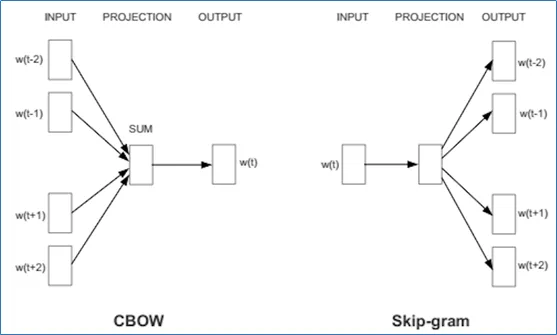

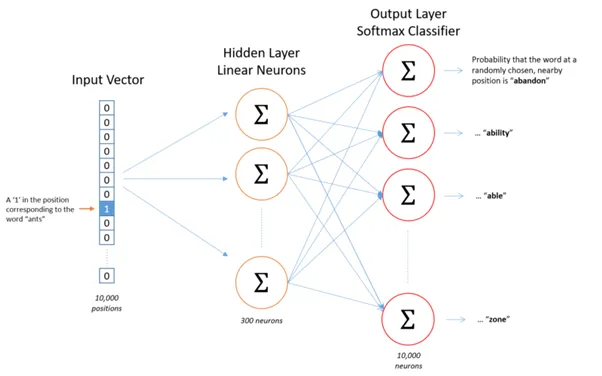

In [44]:
data = pd.read_csv('../../Data/cleanedJobs.csv')
print(data.shape)
data.head()


(15000, 11)


,JobRefNo,DigerPozisyon,Qualifications,Classification,Qualifications_HtmlFree,categorical_label,Length,Word_count,mean_word_length,mean_sent_length,Clean
0,3464108,Bilgisayar Mühendisi,<p>3464105346410534641053464105346410534641053...,Bilgi Teknolojileri,3464105346410534641053464105346410534641053464...,1,126,1,126.000000,126.0,3464105346410534641053464105346410534641053464...
1,3464068,Yazılım Geliştirme Elemanı,<p>sskjdkjsdksajl sksakjdlkajdladl dskjlksjlks...,Bilgi Teknolojileri,sskjdkjsdksajl sksakjdlkajdladl dskjlksjlksajl...,1,111,5,21.400000,111.0,sskjdkjsdksajl sksakjdlkajdladl dskjlksjlksajl...
2,3464018,Grafik Tasarımcı,<p>Şartlar</p><p>08.30 - 18.30 arası mesai saa...,Bilgi Teknolojileri,Şartlar 08.30 - 18.30 arası mesai saatleri. Sa...,1,623,81,6.679012,88.0,şartlar 0830 1830 arası mesai saatleri sadece ...
3,3463995,Full Stack Developer,<p>Yeditek Yeni Dijital Teknolojiler A.Ş.</p><...,Bilgi Teknolojileri,Yeditek Yeni Dijital Teknolojiler A.Ş. Yeditek...,1,698,90,6.766667,138.8,yeditek yeni dijital teknolojiler aş yeditek e...
4,3463739,Multimedya Tasarım Uzmanı,<p>Türkiye'de eğitim teknolojileri alanının il...,Bilgi Teknolojileri,Türkiye'de eğitim teknolojileri alanının ilk v...,1,2426,311,6.729904,484.0,türkiyede eğitim teknolojileri alanının ilk ön...


In [45]:
data.iloc[30]['Qualifications']

'<p class="x_x_x_MsoNormal"><strong>Genel Nitelikler</strong></p><ul type="disc"><li><span>Üniversitelerin ilgili bölümlerinden tercihen mühendislik fakültesi mezunu</span></li><li><span>Minimum 5 yıl Network ve Data Center teknolojilerinde tecrübeli</span></li><li><span>MPLS, L2/L3 VPN, LAN Switching, Data Center Switching, Cisco ACI ve SD WAN konularından, en az bir kaçında detaylı bilgi ve tecrübeye sahip</span></li><li><span>IOS XR, IOS-XE, NX-OS, ve IOS işletim sistemleri üzerinde konfigurasyon yapacak veya problem çözebilecek düzeyde yeterli tecrübeye sahip</span></li><li><span>Data center migration projelerinde çalışmış</span></li><li><span>Tercihen iyi seviyede İngilizce bilen</span></li></ul><ul type="disc"></ul><p class="x_x_x_MsoNormal"><strong>İş Tanımı</strong></p><ul type="disc"><li><span>Müşterilerden gelen talepler doğrultusunda, hakim olduğu teknolojiler hakkında uzaktan veya yerinde destek vermek</span></li><li><span>Yeni alınan projelerin başlangıcından bitiş tarihin

In [46]:
from bs4 import BeautifulSoup
import nltk
sent_detector = nltk.data.load('tokenizers/punkt/turkish.pickle')
import string
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [48]:
def Tokenize(metin):
    
    #Belli html karakterleri noktaya çeviriyoruz ki cümle sonları daha iyi bulunabilsin
    metin  = str(metin).replace('<br>', ' . ').replace('</p>', ' . ').replace('</br>', ' . ')
    metin = metin.replace('<p>', ' . ').replace('.',' . ').replace('</li>', ' . ')
    
    #bazı karakterleri işlemlerin daha doğru yapılabilmesi adına değiştiriyoruz
    metin = metin.replace('&nbsp;', ' ').replace('“', ' ').replace('·', ' ')
    metin = metin.replace('•', ' ').replace('\xa0', ' ')
    metin = metin.replace('”', ' ').replace('nan', '').replace('\r', '').replace('’', ' ').replace('\n', '')

    metin=metin.lower().replace('i̇','i')
   
    sentences = []
    
    if  not (metin and metin.strip()):
        return sentences       
    
    sentences =  sent_detector.tokenize(metin)  

    #get text with beautifulsoup from every sentence in sentences
    sentences = [ BeautifulSoup(x).get_text(" ") for x in sentences if len(x)>1 ]  

    table = str.maketrans({key: ' ' for key in string.punctuation}) #replace punctuation with space

    sentences = [ x.translate(table) for x in sentences if len(x)>1 ]  

    sentences = [ re.sub(' +',' ',x)  for x in sentences if len(x)>1 ]   
    
    #return if length every element in sentences is greater than 1
    return [ x.strip() for x in sentences if len(x)>2 ]

In [50]:
Tokenize('<p>  Ok allright! </p><br> <p> Cleaned </p>')

['ok allright', 'cleaned']

In [ ]:
corpus[22]

In [51]:
#get column Clean and apply Tokenize function to it and save it to an array
sents = data['Qualifications'].progress_apply(Tokenize).values
corpus = []
for sublist in tqdm(sents):
    for item in sublist:
        temp = item.split()
        if(len(temp)>1):
            corpus.append(temp)
corpus

  0%|          | 0/15000 [00:00<?, ?it/s]/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|██████████| 15000/15000 [00:00<00:00, 33778.92it/s]


[['sskjdkjsdksajl',
  'sksakjdlkajdladl',
  'dskjlksjlksajlksajdlkaj',
  'skdksjdlksadlajdlaj',
  'sjdlksajdlksajdalkjdalkjdlakjlajdla'],
 ['30', '18'],
 ['30', 'arası', 'mesai', 'saatleri'],
 ['sadece', 'pazar', 'günleri', 'çalışmıyoruz'],
 ['yerimiz', 'kızılay', 'kolejdedir'],
 ['orta', 'seviye', 'photoshop', 'zorunlu'],
 ['tercihen', 'adobe', 'premier', 'bilen'],
 ['tercihen', 'orta', 'seviye', 'ingilizce', 'okuma', 've', 'yazma'],
 ['tercihen', 'ürün', 'çekimi', 'konusunda', 'tecrübeli'],
 ['işin', 'tanımı'],
 ['grafik',
  'tasarımın',
  'yanı',
  'sıra',
  'idari',
  'işlerde',
  'yardımcı',
  'olacak',
  'ekip',
  'arkadaşı',
  'ihtiyacımız',
  'vardır'],
 ['siparişleri',
  'ayarlama',
  'kargo',
  'paketleme',
  'baskı',
  'makinalarının',
  'kullanımı',
  'gibi',
  'gün',
  'içinde',
  'bizler',
  'ne',
  'yapıyorsak',
  'yardımcı',
  'olacak',
  'personel',
  'işe',
  'alınacaktır'],
 ['ara',
  'sıra',
  'adobe',
  'premier',
  've',
  'photoshopta',
  'projeler',
  'verilecek

In [52]:
phrases = Phrases(sentences=corpus)
bigram = Phraser(phrases)

for index,sentence in enumerate(tqdm(corpus)):
    corpus[index] = bigram[sentence]

100%|██████████| 254871/254871 [00:00<00:00, 326331.38it/s]


In [53]:
phrases2_tri = Phrases(sentences=corpus)
trigram = Phraser(phrases2_tri)

for index,sentence in enumerate(tqdm(corpus)):
    corpus[index] = trigram[sentence]

100%|██████████| 254871/254871 [00:00<00:00, 361134.48it/s]


In [54]:
phrases3_four = Phrases(sentences=corpus)
fourgram = Phraser(phrases3_four)

for index,sentence in enumerate(tqdm(corpus)):
    corpus[index] = fourgram[sentence]

100%|██████████| 254871/254871 [00:00<00:00, 358269.30it/s]


In [55]:
corpus

[['sskjdkjsdksajl',
  'sksakjdlkajdladl',
  'dskjlksjlksajlksajdlkaj',
  'skdksjdlksadlajdlaj',
  'sjdlksajdlksajdalkjdalkjdlakjlajdla'],
 ['30_18'],
 ['30', 'arası', 'mesai_saatleri'],
 ['sadece', 'pazar_günleri', 'çalışmıyoruz'],
 ['yerimiz', 'kızılay', 'kolejdedir'],
 ['orta_seviye', 'photoshop', 'zorunlu'],
 ['tercihen', 'adobe_premier', 'bilen'],
 ['tercihen', 'orta_seviye', 'ingilizce_okuma', 've', 'yazma'],
 ['tercihen', 'ürün', 'çekimi', 'konusunda_tecrübeli'],
 ['işin_tanımı'],
 ['grafik',
  'tasarımın',
  'yanı_sıra',
  'idari',
  'işlerde',
  'yardımcı_olacak',
  'ekip_arkadaşı',
  'ihtiyacımız_vardır'],
 ['siparişleri',
  'ayarlama',
  'kargo',
  'paketleme',
  'baskı',
  'makinalarının',
  'kullanımı',
  'gibi',
  'gün_içinde',
  'bizler',
  'ne',
  'yapıyorsak',
  'yardımcı_olacak',
  'personel',
  'işe_alınacaktır'],
 ['ara',
  'sıra',
  'adobe_premier',
  've',
  'photoshopta',
  'projeler',
  'verilecektir',
  'bu_nedenle',
  'bilen',
  'kişileri',
  'tercih',
  'ediyo

In [56]:
model = Word2Vec(corpus)# vector_size==100, window=5, min_count=5
model.train(corpus, total_examples=len(corpus), epochs=15)


(19353794, 22342995)

In [59]:
model.wv.most_similar('hukuk')

[('icra', 0.727268397808075),
 ('arabuluculuk', 0.6488009095191956),
 ('yasal_takip', 0.6382808685302734),
 ('dava', 0.6362298130989075),
 ('hukuki_danışmanlık', 0.6282283067703247),
 ('hukuk_müşavirliği', 0.6214642524719238),
 ('özellikle_iş_hukuku', 0.6182859539985657),
 ('hukuk_danışmanlık', 0.6167138814926147),
 ('bilgi_işlem', 0.6095423698425293),
 ('şirketlerin', 0.6045704483985901)]

In [60]:
print(model.wv.similarity('javascript', 'vue'))
print(model.wv.similarity('javascript', 'engineer'))

0.8339558
0.41325402


In [61]:
model.wv.doesnt_match(['python', 'military', 'java'])

'military'

In [62]:
model.wv.most_similar(positive=["ankara", "istanbul"], negative=["kızılay"], topn=3)

[('izmir', 0.7656890153884888),
 ('antalya', 0.7164641618728638),
 ('gebze', 0.7013428807258606)]

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def display_pca_scatterplot(model, words=None, sample=0):

    word_vectors = np.array([model.wv.get_vector(w) for w in words]) 

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
        #plt.text(x+0.05, y+0.05, word, fontsize=10)

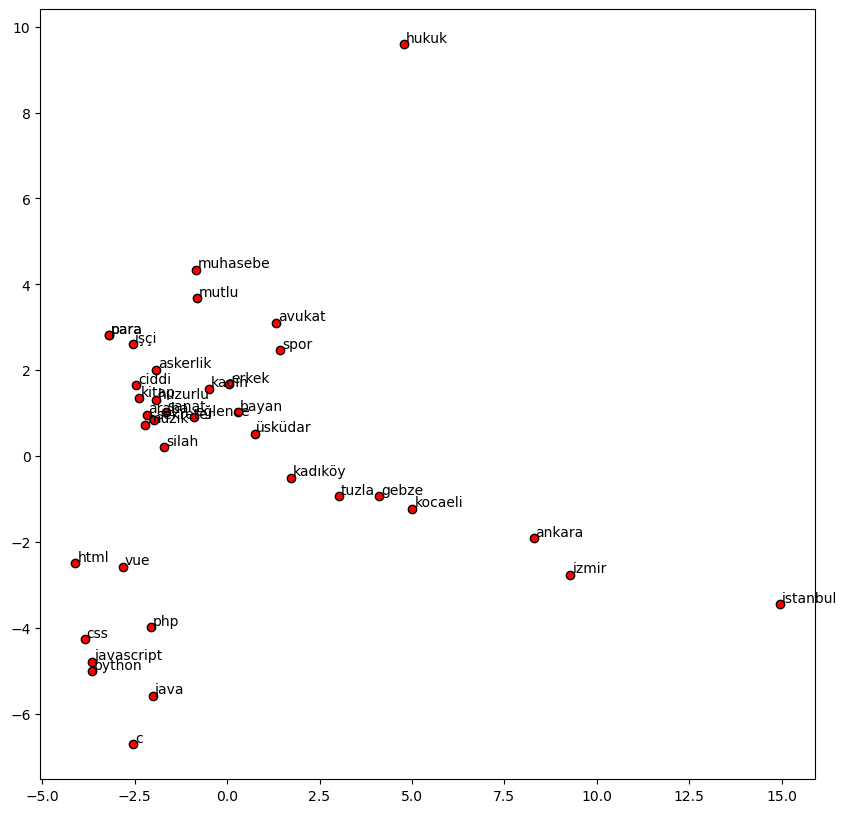

In [66]:
display_pca_scatterplot(model, 
                        ['istanbul', 'gebze', 'ankara', 'izmir', 'kocaeli', 'tuzla', 'kadıköy', 'üsküdar',
                         'kadın', 'erkek','python','vue','javascript','java','c','php','html','css',
                         'askerlik', 'spor', 'müzik', 'eğlence', 'sanat', 'kitap', 'silah',
                          'muhasebe', 'para', 'para', 'avukat', 'hukuk', 'mutlu', 'ciddi', 'huzurlu', 'bayan',
                         'sekreter','işçi','araba'])

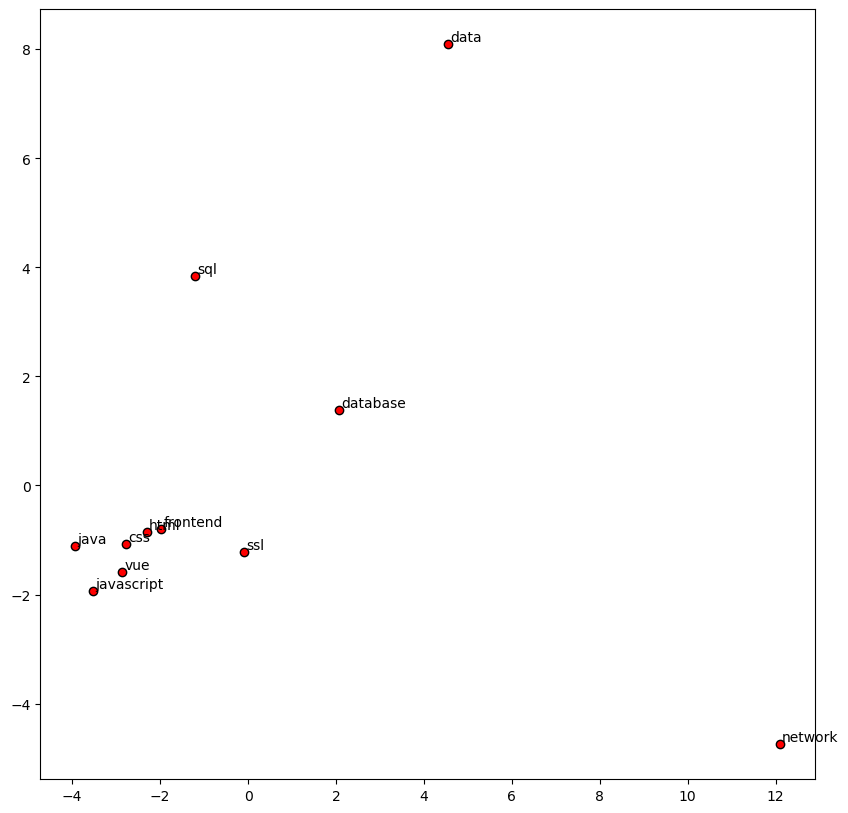

In [40]:
display_pca_scatterplot(model, 
                        ['java','sql','database','vue','frontend','javascript','ssl','network','html','css','data',])